# EcoFOCIpy RCM vs ADCP

Compare data using the ERDDAP hosted datasets for both instruments:
- 2D EIN/Vel datasets for the ADCP
- 1D dataset (at a specific depth) embedded in the mooring dataset


In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import datetime
import EcoFOCIpy.io.erddap as erddap

url = "http://akutan.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [4]:
rcm_data = erddap.erddapMooredInstretrieve(url=url,mooringid='24ckp3a',qclevel='final',instrid='24ckp3a_rcmsg_0040m')
rcm_data.columns = [x.split()[0] for x in rcm_data.columns]

/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/erddapy/core/interfaces.py:39: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(data, **(pandas_kwargs or {}))


In [5]:
rcm_data = rcm_data.set_index(pd.to_datetime(rcm_data['time'])).tz_localize(None).drop('time',axis=1)

In [6]:
adcp_data = xr.load_dataset(url+'/griddap/ADCP_Mooring_24ckp3a_final')

/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'agc1' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'agc2' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'agc3' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/Users/bell/mambaforge/envs/p312/lib/python3.12/site-packages/xarray/conventions.py:204: SerializationWarning: variable 'agc4' has multiple fill values {1e+35, -9999.0} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [7]:
adcp_rcm_depth = adcp_data.sel(depth=(rcm_data['depth'].median()), method="nearest").to_dataframe().droplevel(['latitude','longitude'])

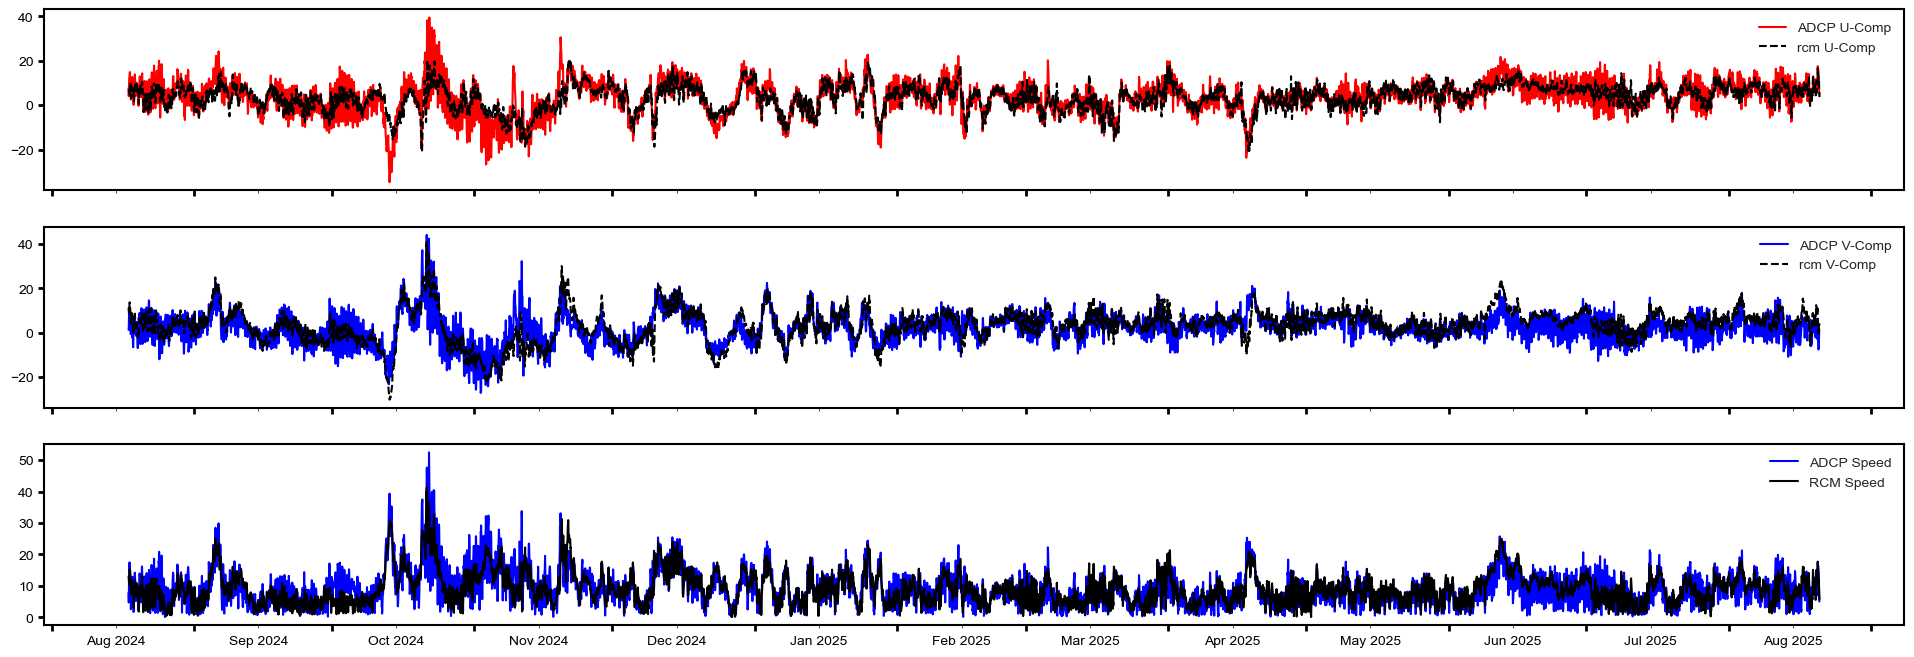

In [8]:
#wrap the plot in image settings for visual appeal
# may be able to make this cleaner or just a preset
# copy is in the notebook examples
%run '../../../settings/mpl_plot_settings.py'

%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.dates import YearLocator, WeekdayLocator, MonthLocator, DayLocator, HourLocator, DateFormatter
import matplotlib.ticker as ticker


fig, ax = plt.subplots(3,figsize=(24, 8),sharex=True)
ax[0].plot(adcp_rcm_depth.index,adcp_rcm_depth.u_comp_current,color='r',label='ADCP U-Comp')
ax[1].plot(adcp_rcm_depth.index,adcp_rcm_depth.v_comp_current,color='b',label='ADCP V-Comp')
ax[2].plot(adcp_rcm_depth.index,
           np.sqrt(adcp_rcm_depth.v_comp_current**2 + adcp_rcm_depth.u_comp_current**2),
           color='b',label='ADCP Speed')
ax[0].plot(rcm_data.index,rcm_data.u_comp_current,'k--',label='rcm U-Comp')
ax[1].plot(rcm_data.index,rcm_data.v_comp_current,'k--',label='rcm V-Comp')
ax[2].plot(rcm_data.index,
           np.sqrt(rcm_data.v_comp_current**2 + rcm_data.u_comp_current**2),
           color='k',label='RCM Speed')
ax[0].legend()
ax[1].legend()
ax[2].legend()

xfmt = mdates.DateFormatter('%d-%b')
ax[2].xaxis.set_major_locator(DayLocator(bymonthday=1))
ax[2].xaxis.set_minor_locator(DayLocator(bymonthday=15))
ax[2].xaxis.set_minor_formatter(DateFormatter('%b %Y'))
ax[2].xaxis.set_major_formatter(DateFormatter(''))
ax[2].xaxis.set_tick_params(which='major', pad=3)
ax[2].xaxis.set_tick_params(which='minor', pad=5)